In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys
sys.path.insert(0,'/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms
import cv2

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [3]:
s = ShapeDataset(n_images = 2,n_circles=1,n_rectangles=1)
s.gen_dataset()

Num Circle: 1
Num Circle+Rect: 2
Num Anns: 3
[{'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [271, 3, 60, 60], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [171, 331, 32, 32], 'category_id': 1, 'id': 2}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}]
Num Circle: 1
Num Circle+Rect: 2
Num Anns: 5
[{'segmentation': [], 'area': 3600, 'iscrowd': 0, 'image_id': 1, 'bbox': [271, 3, 60, 60], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [171, 331, 32, 32], 'category_id': 1, 'id': 2}, {'segmentation': [], 'area': 3844, 'iscrowd': 0, 'image_id': 2, 'bbox': [224, 69, 62, 62], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 2, 'bbox': [48, 28, 32, 32], 'category_id': 1, 'id': 4}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}, {'file_name': 'dummy_2.png', 'height': 512, 'width': 512,

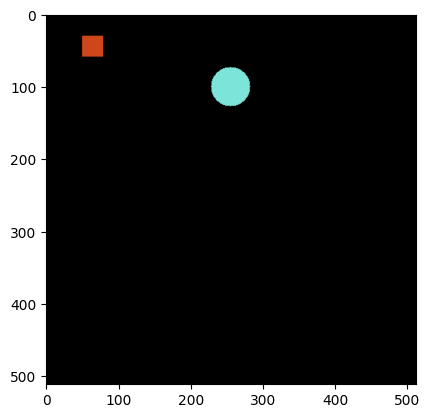

In [4]:
im = Image.open('dummy_2.png')
plt.imshow(im)

In [5]:
ds = COCODetectionDataset(img_dir='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial',
                ann_json='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm)
val_ds = COCODetectionDataset(img_dir='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial',
                ann_json='/Users/mendeza/Documents/projects/cent-tutorial/centernet-tutorial/tutorial/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=validation_transform_norm)
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=2,
                                        shuffle=True,
                                        num_workers=8,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


In [6]:
len(ds)

2

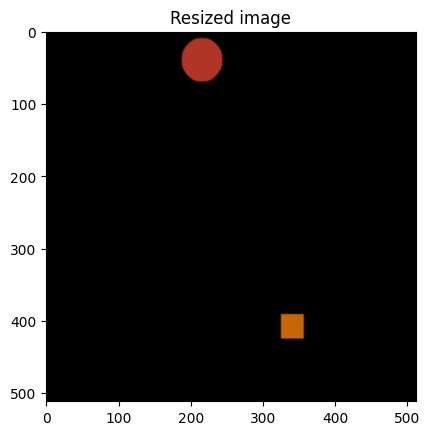

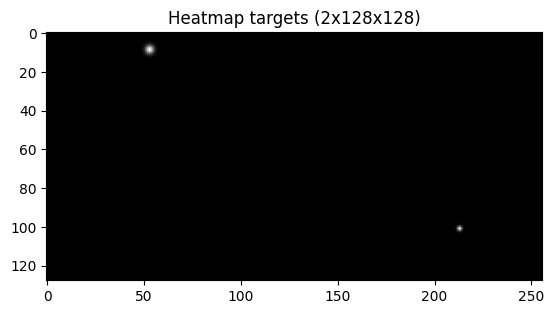

In [7]:
img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target= ds[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Single Stage vs Two Stage
<a id='single-vs-two-stage'></a>

## Centernet

# Preprocessing

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [8]:
model = centernet(ds.num_classes,model_name='mv3')

/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [23]:
# LR = 1e-4
LR = 2.5e-4*2
model_mv3, losses, mask_losses, regr_losses, min_confidences, median_confidences, max_confidences = train('mv3',
                                                                                                          ds.num_classes,
                                                                                                          learn_rate=LR,
                                                                                                          epochs=300,
                                                                                                          train_loader=train_loader,
                                                                                                          val_loader=val_loader)

  0%|          | 1/300 [00:08<39:57,  8.02s/it]

Epoch 0 - Min conf: 0.01102310512214899, Median conf: 0.09974035620689392, Max conf: 0.7726437449455261
Epoch 0 - Loss: 21.187549591064453, Mask Loss: 16.900136947631836, Reg Loss: 4.287412166595459


  1%|          | 2/300 [00:16<39:50,  8.02s/it]

Epoch 1 - Min conf: 1.251454341399949e-05, Median conf: 0.10960378497838974, Max conf: 0.25124889612197876
Epoch 1 - Loss: 25.259113311767578, Mask Loss: 23.205547332763672, Reg Loss: 2.05356502532959


  1%|          | 3/300 [00:24<39:50,  8.05s/it]

Epoch 2 - Min conf: 7.637168891960755e-05, Median conf: 0.09397392719984055, Max conf: 0.9853547811508179
Epoch 2 - Loss: 247.61932373046875, Mask Loss: 245.68128967285156, Reg Loss: 1.9380325078964233


  1%|▏         | 4/300 [00:32<39:33,  8.02s/it]

Epoch 3 - Min conf: 1.0097043741552625e-05, Median conf: 0.09462384879589081, Max conf: 0.22331123054027557
Epoch 3 - Loss: 15.873183250427246, Mask Loss: 13.097392082214355, Reg Loss: 2.7757914066314697


  2%|▏         | 5/300 [00:40<39:26,  8.02s/it]

Epoch 4 - Min conf: 5.504196087713353e-05, Median conf: 0.09408852458000183, Max conf: 0.1829654425382614
Epoch 4 - Loss: 17.547082901000977, Mask Loss: 15.621755599975586, Reg Loss: 1.9253265857696533


  2%|▏         | 6/300 [00:48<39:59,  8.16s/it]

Epoch 5 - Min conf: 1.7751245877661859e-06, Median conf: 0.08953136950731277, Max conf: 0.205713152885437
Epoch 5 - Loss: 14.452014923095703, Mask Loss: 13.017148971557617, Reg Loss: 1.4348664283752441


  2%|▏         | 7/300 [00:56<39:38,  8.12s/it]

Epoch 6 - Min conf: 2.60190404333116e-07, Median conf: 0.08696533739566803, Max conf: 0.3052523136138916
Epoch 6 - Loss: 12.091172218322754, Mask Loss: 8.734977722167969, Reg Loss: 3.356194257736206


  3%|▎         | 8/300 [01:04<39:29,  8.12s/it]

Epoch 7 - Min conf: 6.561664633863984e-08, Median conf: 0.08153223991394043, Max conf: 0.1560245156288147
Epoch 7 - Loss: 9.984735488891602, Mask Loss: 8.092724800109863, Reg Loss: 1.8920106887817383


  3%|▎         | 9/300 [01:12<39:17,  8.10s/it]

Epoch 8 - Min conf: 3.610935834785778e-07, Median conf: 0.08106446266174316, Max conf: 0.15696915984153748
Epoch 8 - Loss: 8.917009353637695, Mask Loss: 6.866629600524902, Reg Loss: 2.050379991531372


  3%|▎         | 10/300 [01:20<39:08,  8.10s/it]

Epoch 9 - Min conf: 1.1291932651147363e-06, Median conf: 0.07929729670286179, Max conf: 0.17641545832157135
Epoch 9 - Loss: 8.703278541564941, Mask Loss: 6.3146257400512695, Reg Loss: 2.3886525630950928


  4%|▎         | 11/300 [01:29<39:05,  8.11s/it]

Epoch 10 - Min conf: 4.053642442158889e-06, Median conf: 0.07542811334133148, Max conf: 0.16668881475925446
Epoch 10 - Loss: 7.98190975189209, Mask Loss: 6.420651435852051, Reg Loss: 1.5612585544586182


  4%|▍         | 12/300 [01:37<38:54,  8.11s/it]

Epoch 11 - Min conf: 5.564289722315152e-07, Median conf: 0.07510095834732056, Max conf: 0.199480339884758
Epoch 11 - Loss: 7.064011573791504, Mask Loss: 4.918992519378662, Reg Loss: 2.1450188159942627


  4%|▍         | 13/300 [01:45<38:47,  8.11s/it]

Epoch 12 - Min conf: 4.949062031300855e-07, Median conf: 0.07246823608875275, Max conf: 0.161653533577919
Epoch 12 - Loss: 7.028324127197266, Mask Loss: 5.391674041748047, Reg Loss: 1.6366500854492188


  5%|▍         | 14/300 [01:53<38:33,  8.09s/it]

Epoch 13 - Min conf: 5.569290806306526e-08, Median conf: 0.07204671949148178, Max conf: 0.17092616856098175
Epoch 13 - Loss: 6.915534019470215, Mask Loss: 5.708741188049316, Reg Loss: 1.2067927122116089


  5%|▌         | 15/300 [02:01<38:19,  8.07s/it]

Epoch 14 - Min conf: 3.122838734270772e-07, Median conf: 0.07335447520017624, Max conf: 0.21073465049266815
Epoch 14 - Loss: 6.542877197265625, Mask Loss: 4.457607746124268, Reg Loss: 2.0852692127227783


  5%|▌         | 16/300 [02:09<38:13,  8.07s/it]

Epoch 15 - Min conf: 3.944874649164376e-08, Median conf: 0.07180806249380112, Max conf: 0.2850631773471832
Epoch 15 - Loss: 6.477295875549316, Mask Loss: 4.424798488616943, Reg Loss: 2.052497625350952


  6%|▌         | 17/300 [02:17<38:00,  8.06s/it]

Epoch 16 - Min conf: 2.295064547297443e-07, Median conf: 0.06995850801467896, Max conf: 0.20391729474067688
Epoch 16 - Loss: 5.613753318786621, Mask Loss: 4.03076171875, Reg Loss: 1.582991361618042


  6%|▌         | 18/300 [02:25<37:56,  8.07s/it]

Epoch 17 - Min conf: 3.2462775578778746e-08, Median conf: 0.06939774006605148, Max conf: 0.23587225377559662
Epoch 17 - Loss: 5.397546768188477, Mask Loss: 4.032963275909424, Reg Loss: 1.3645836114883423


  6%|▋         | 19/300 [02:33<38:08,  8.14s/it]

Epoch 18 - Min conf: 5.984100681644122e-08, Median conf: 0.06743345409631729, Max conf: 0.25336453318595886
Epoch 18 - Loss: 5.217613697052002, Mask Loss: 4.086280345916748, Reg Loss: 1.131333351135254


  7%|▋         | 20/300 [02:41<37:53,  8.12s/it]

Epoch 19 - Min conf: 1.3057539050009837e-08, Median conf: 0.0655800998210907, Max conf: 0.28960147500038147
Epoch 19 - Loss: 4.449413299560547, Mask Loss: 3.4933340549468994, Reg Loss: 0.9560791850090027


  7%|▋         | 21/300 [02:49<37:40,  8.10s/it]

Epoch 20 - Min conf: 1.426739282273104e-09, Median conf: 0.06437389552593231, Max conf: 0.2654538154602051
Epoch 20 - Loss: 4.430276870727539, Mask Loss: 3.376694679260254, Reg Loss: 1.0535823106765747


  7%|▋         | 22/300 [02:58<37:32,  8.10s/it]

Epoch 21 - Min conf: 5.6968616490848945e-08, Median conf: 0.06195569783449173, Max conf: 0.2838486135005951
Epoch 21 - Loss: 5.003467082977295, Mask Loss: 3.200237274169922, Reg Loss: 1.8032299280166626


  8%|▊         | 23/300 [03:06<37:22,  8.09s/it]

Epoch 22 - Min conf: 2.0843300774231466e-07, Median conf: 0.060795776546001434, Max conf: 0.24722525477409363
Epoch 22 - Loss: 4.078587532043457, Mask Loss: 3.4694647789001465, Reg Loss: 0.6091225743293762


  8%|▊         | 24/300 [03:14<37:11,  8.09s/it]

Epoch 23 - Min conf: 4.009527998505291e-08, Median conf: 0.05915936827659607, Max conf: 0.191977396607399
Epoch 23 - Loss: 5.582773208618164, Mask Loss: 3.4589357376098633, Reg Loss: 2.12383770942688


  8%|▊         | 25/300 [03:22<37:04,  8.09s/it]

Epoch 24 - Min conf: 3.222495692511984e-08, Median conf: 0.05784369632601738, Max conf: 0.24138334393501282
Epoch 24 - Loss: 3.908125400543213, Mask Loss: 3.1879451274871826, Reg Loss: 0.7201803922653198


  9%|▊         | 26/300 [03:30<37:09,  8.14s/it]

Epoch 25 - Min conf: 4.0579499760440285e-09, Median conf: 0.05769959092140198, Max conf: 0.22637435793876648
Epoch 25 - Loss: 3.7250020503997803, Mask Loss: 2.9378371238708496, Reg Loss: 0.7871648669242859


  9%|▉         | 27/300 [03:38<37:00,  8.13s/it]

Epoch 26 - Min conf: 1.4115610724729777e-07, Median conf: 0.05510878562927246, Max conf: 0.21880775690078735
Epoch 26 - Loss: 3.8713738918304443, Mask Loss: 3.3763887882232666, Reg Loss: 0.4949851334095001


  9%|▉         | 28/300 [03:46<36:50,  8.13s/it]

Epoch 27 - Min conf: 1.4203891396391555e-08, Median conf: 0.05466005206108093, Max conf: 0.3143804669380188
Epoch 27 - Loss: 3.294931411743164, Mask Loss: 2.7206857204437256, Reg Loss: 0.5742456316947937


 10%|▉         | 29/300 [03:54<36:38,  8.11s/it]

Epoch 28 - Min conf: 9.693032154700632e-09, Median conf: 0.05193333327770233, Max conf: 0.33471059799194336
Epoch 28 - Loss: 4.4410481452941895, Mask Loss: 3.4133405685424805, Reg Loss: 1.027707576751709


 10%|█         | 30/300 [04:03<36:36,  8.13s/it]

Epoch 29 - Min conf: 6.969232657638713e-08, Median conf: 0.05134887993335724, Max conf: 0.2562263011932373
Epoch 29 - Loss: 4.94942569732666, Mask Loss: 3.8657803535461426, Reg Loss: 1.0836453437805176


 10%|█         | 31/300 [04:11<36:28,  8.14s/it]

Epoch 30 - Min conf: 1.690615825111763e-08, Median conf: 0.05147704482078552, Max conf: 0.15358804166316986
Epoch 30 - Loss: 3.5474815368652344, Mask Loss: 2.7992119789123535, Reg Loss: 0.7482694983482361


 11%|█         | 32/300 [04:19<36:20,  8.14s/it]

Epoch 31 - Min conf: 1.6422168869212328e-07, Median conf: 0.05069856718182564, Max conf: 0.14814387261867523
Epoch 31 - Loss: 3.1224794387817383, Mask Loss: 2.6092019081115723, Reg Loss: 0.5132774114608765


 11%|█         | 33/300 [04:27<36:07,  8.12s/it]

Epoch 32 - Min conf: 4.8073790281932816e-08, Median conf: 0.04913933575153351, Max conf: 0.15086884796619415
Epoch 32 - Loss: 3.197087287902832, Mask Loss: 2.4346461296081543, Reg Loss: 0.7624410390853882


 11%|█▏        | 34/300 [04:35<35:55,  8.10s/it]

Epoch 33 - Min conf: 9.02627039778281e-09, Median conf: 0.04973945766687393, Max conf: 0.18955262005329132
Epoch 33 - Loss: 3.9548261165618896, Mask Loss: 2.5570120811462402, Reg Loss: 1.3978140354156494


 12%|█▏        | 35/300 [04:43<35:51,  8.12s/it]

Epoch 34 - Min conf: 4.238331996475608e-08, Median conf: 0.04751621186733246, Max conf: 0.1815016269683838
Epoch 34 - Loss: 3.110856056213379, Mask Loss: 2.5294747352600098, Reg Loss: 0.5813812017440796


 12%|█▏        | 36/300 [04:51<35:48,  8.14s/it]

Epoch 35 - Min conf: 1.5292096477992345e-08, Median conf: 0.046184297651052475, Max conf: 0.2488984316587448
Epoch 35 - Loss: 3.2757694721221924, Mask Loss: 2.2995245456695557, Reg Loss: 0.9762449264526367


 12%|█▏        | 37/300 [04:59<35:45,  8.16s/it]

Epoch 36 - Min conf: 1.22135770652676e-06, Median conf: 0.04536263644695282, Max conf: 0.32196012139320374
Epoch 36 - Loss: 3.753281831741333, Mask Loss: 2.369757652282715, Reg Loss: 1.3835241794586182


 13%|█▎        | 38/300 [05:08<35:38,  8.16s/it]

Epoch 37 - Min conf: 1.9599376344103803e-07, Median conf: 0.044197775423526764, Max conf: 0.2444612681865692
Epoch 37 - Loss: 2.808765411376953, Mask Loss: 2.1577517986297607, Reg Loss: 0.6510135531425476


 13%|█▎        | 39/300 [05:16<35:31,  8.17s/it]

Epoch 38 - Min conf: 4.681547125073848e-06, Median conf: 0.044096413999795914, Max conf: 0.2724456787109375
Epoch 38 - Loss: 3.1545984745025635, Mask Loss: 2.2415249347686768, Reg Loss: 0.9130735993385315


 13%|█▎        | 40/300 [05:24<35:17,  8.14s/it]

Epoch 39 - Min conf: 1.6559495463752683e-07, Median conf: 0.04211609065532684, Max conf: 0.3012852370738983
Epoch 39 - Loss: 3.2488880157470703, Mask Loss: 2.410647392272949, Reg Loss: 0.8382406830787659


 14%|█▎        | 41/300 [05:32<35:06,  8.13s/it]

Epoch 40 - Min conf: 4.605705612448219e-07, Median conf: 0.04438487067818642, Max conf: 0.2051016241312027
Epoch 40 - Loss: 3.502904176712036, Mask Loss: 2.640812873840332, Reg Loss: 0.8620912432670593


 14%|█▍        | 42/300 [05:40<34:55,  8.12s/it]

Epoch 41 - Min conf: 3.1902993669064017e-06, Median conf: 0.041029270738363266, Max conf: 0.2110012173652649
Epoch 41 - Loss: 2.925466537475586, Mask Loss: 2.370988607406616, Reg Loss: 0.554477870464325


 14%|█▍        | 43/300 [05:48<34:43,  8.11s/it]

Epoch 42 - Min conf: 3.2822052276060276e-07, Median conf: 0.04144265875220299, Max conf: 0.20520274341106415
Epoch 42 - Loss: 2.626736640930176, Mask Loss: 2.1878485679626465, Reg Loss: 0.4388880431652069


 15%|█▍        | 44/300 [05:56<34:29,  8.08s/it]

Epoch 43 - Min conf: 2.2342541683428863e-07, Median conf: 0.0412440225481987, Max conf: 0.15201598405838013
Epoch 43 - Loss: 2.8232250213623047, Mask Loss: 2.284895896911621, Reg Loss: 0.538329005241394


 15%|█▌        | 45/300 [06:04<34:29,  8.12s/it]

Epoch 44 - Min conf: 9.946051093834285e-09, Median conf: 0.04203570634126663, Max conf: 0.1835639327764511
Epoch 44 - Loss: 2.5141608715057373, Mask Loss: 2.037865400314331, Reg Loss: 0.4762954115867615


 15%|█▌        | 46/300 [06:12<34:15,  8.09s/it]

Epoch 45 - Min conf: 9.729823347015554e-08, Median conf: 0.040227629244327545, Max conf: 0.20617260038852692
Epoch 45 - Loss: 2.3587958812713623, Mask Loss: 1.9842406511306763, Reg Loss: 0.37455523014068604


In [22]:
len(losses)

50

In [14]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18 = train('resnet18',
                                                                                    ds.num_classes,
                                                                                    learn_rate=1e-4,
                                                                                    epochs=300,
                                                                                    train_loader=train_loader,
                                                                                    val_loader=val_loader)


  0%|          | 0/50 [00:00<?, ?it/s]

nan
Loss: 14.860170364379883, Mask Loss: 11.81452751159668, Reg Loss: 3.0456433296203613


  2%|▏         | 1/50 [00:08<06:36,  8.08s/it]

0.021644711
Loss: 18.35923957824707, Mask Loss: 17.106542587280273, Reg Loss: 1.2526977062225342


  4%|▍         | 2/50 [00:16<06:31,  8.15s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/site-packages/torch/__init__.py", line 202, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    from torch._C import *  # noqa: F403
RuntimeError: KeyboardInterrupt: 


# Visualize Loss Curves

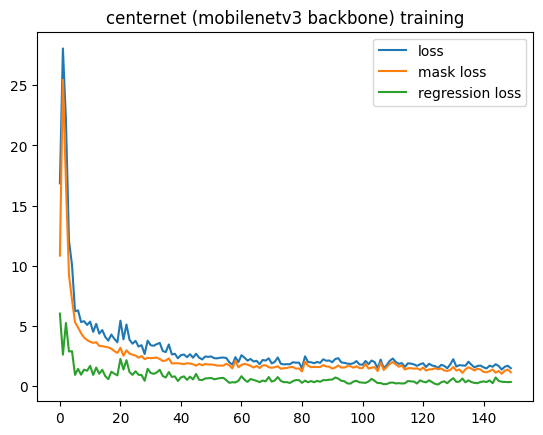

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

## Visualize Confidence Scores over training

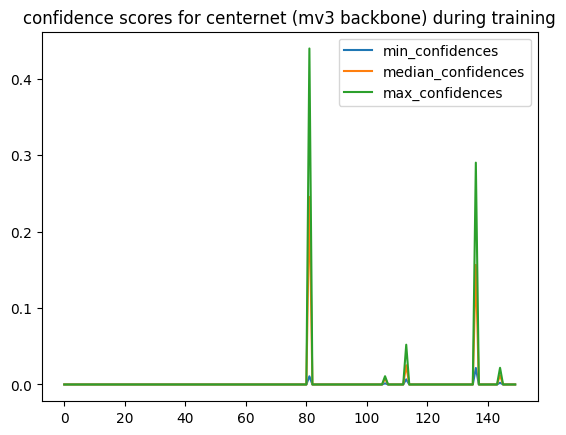

In [17]:
plt.plot(range(len(min_confidences)),min_confidences )
plt.plot(range(len(median_confidences)),median_confidences)
plt.plot(range(len(max_confidences)),max_confidences)
plt.title("confidence scores for centernet (mv3 backbone) during training")
plt.legend(['min_confidences','median_confidences','max_confidences'])
plt.show()

## Visualize Training Loss for Resnet18

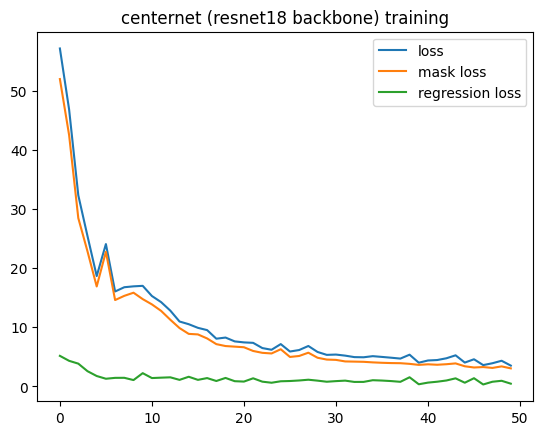

In [30]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

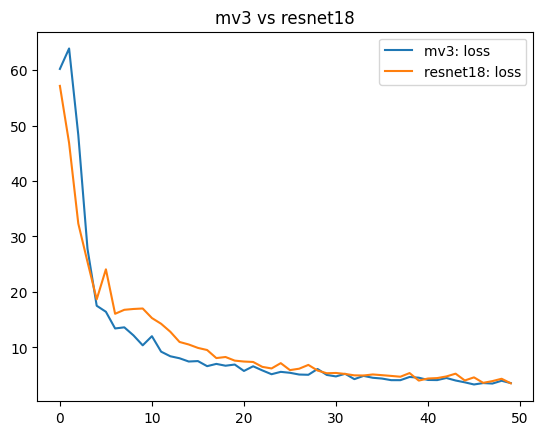

In [26]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [101]:
# model_mv3(torch.rand(1,3,512,512))

In [20]:
model_mv3.eval()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale,boxes_aug, target in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.05)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.45,n_top_scores=20)
print(bboxes)

[[128. 122. 128. 122.]
 [128. 124. 128. 124.]
 [128. 123. 128. 123.]
 [128. 124. 128. 124.]
 [128. 124. 128. 124.]
 [128. 122. 128. 122.]]


In [62]:
hm.shape

torch.Size([1, 2, 128, 128])

Traceback (most recent call last):
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/Users/mendeza/miniforge3/envs/centernet-tutorial/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self.

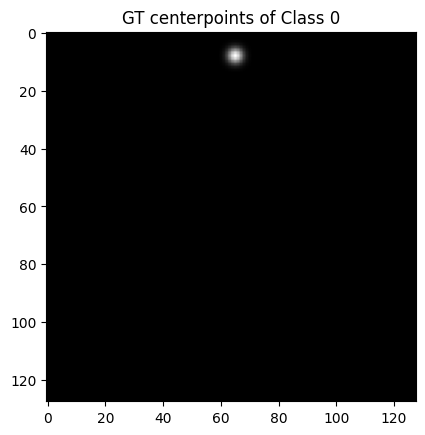

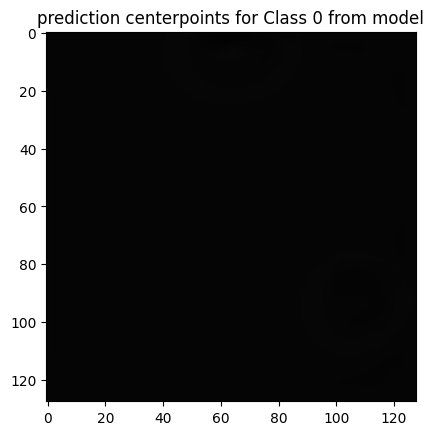

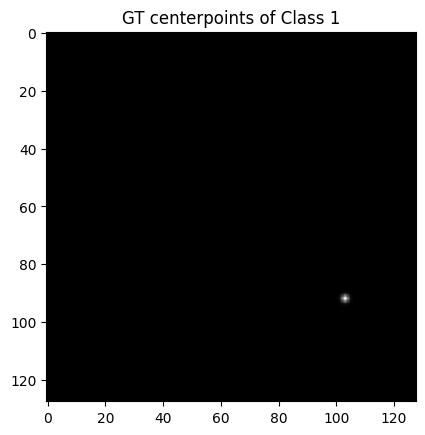

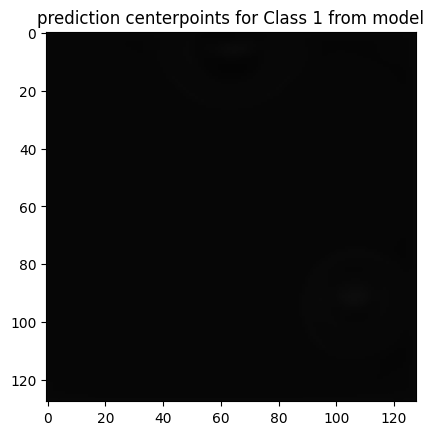

In [21]:
for i in range(hm.shape[1]):
    hm_gt = hm[0].data.numpy()[i]
    hm_pred = pred_hm[0].data.numpy()[i]
    hm_pred = np.dstack([hm_pred*255]*3).astype(np.uint8)
    for b,c in zip(bboxes,classes):
        if c == i:
            x,y,x2,y2 = [int(k) for k in b]
            # print(x,y)
            cv2.rectangle(hm_pred,(x,y),(x2,y2),(255,0,0),1)
        
    plt.imshow(hm_gt,cmap='gray')
    plt.title("GT centerpoints of Class {}".format(i))
    plt.show()
    plt.imshow(hm_pred)
    plt.title("prediction centerpoints for Class {} from model".format(i))
    plt.show()
